In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# --- Model Parameters ---
mu_max = 0.86980    # 1/h
Ks = 0.000123762    # g/l
Yxs = 0.435749      # g/g
Sin = 286           # g/l

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

T_START = 0
T_END = 5
dt = 0.1  # Time step
time = np.arange(T_START, T_END, dt)

F_min, F_max = 0, 0.1       # Feed bounds [L/h]

# Plant Model
def system_dynamics(t, y, F):
    X, S, V = y
    S = max(S, 0)
    mu = mu_max * S / (Ks + S)
    dXdt = mu * X - (F / V) * X
    dSdt = -(1 / Yxs) * mu * X + (F / V) * (Sin - S)
    dVdt = F
    return [dXdt, dSdt, dVdt]

# PID Controller
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint=0.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, measured_value, dt):
        error = self.setpoint - measured_value
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0

        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

setpoint = 25.0

# Storage
X = X_0
S = S_0
V = V_0
F = 0.0
X_hist = [X_0]
S_hist = [S_0]
V_hist = [V_0]
F_hist = [F]
t_hist = [time[0]]

# PID Controller 
pid = PID(Kp=0.5, Ki=0.1, Kd=0.05, setpoint=setpoint)

for i in range(1, len(time)):
    t = time[i-1]
    # Update PID and solve system
    p = pid.update(X, dt)
    p = np.clip(p, F_min, F_max)
    # Solve ODE
    sol = solve_ivp(system_dynamics, [t, t+dt], [X, S, V], args=(p,), method='RK45', t_eval=[t+dt])
    X, S, V = sol.y[:,-1]    
    X_hist.append(X)
    S_hist.append(S)
    V_hist.append(V)
    F_hist.append(p)    
    t_hist.append(t + dt)    

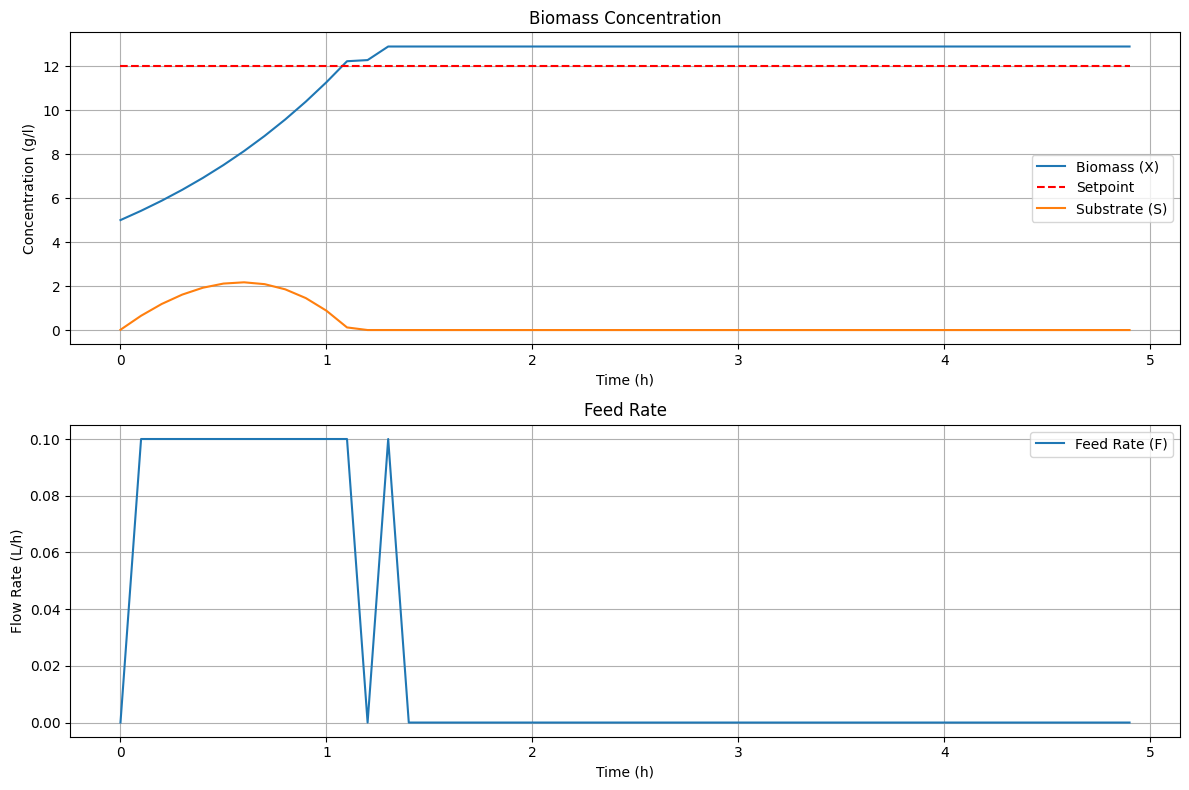

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(t_hist, X_hist, label='Biomass (X)')
plt.plot(t_hist, [setpoint]*len(t_hist), 'r--', label='Setpoint')
plt.plot(t_hist, S_hist, label='Substrate (S)')
plt.title('Biomass Concentration')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(t_hist, F_hist, label='Feed Rate (F)')
plt.title('Feed Rate')
plt.xlabel('Time (h)')
plt.ylabel('Flow Rate (L/h)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
